<a href="https://colab.research.google.com/github/insyspo/scielo/blob/main/SciELO_metrics_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Only if you are running in Colab. For locally running, follow instructions on
# local instalation of Python, Google Authentication.

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# SciELO evolution

In [93]:
%%bigquery df --project=insyspo

SELECT pub_year AS year,
    COUNT(DISTINCT(doi)) AS distinct_dois,
    COUNT(DISTINCT(id)) AS distinct_ids,
FROM publicdb_scielo_2024_rm.works
WHERE pub_year IS NOT NULL
GROUP BY pub_year
ORDER BY pub_year ASC


Query is running:   0%|          |

Downloading:   0%|          |

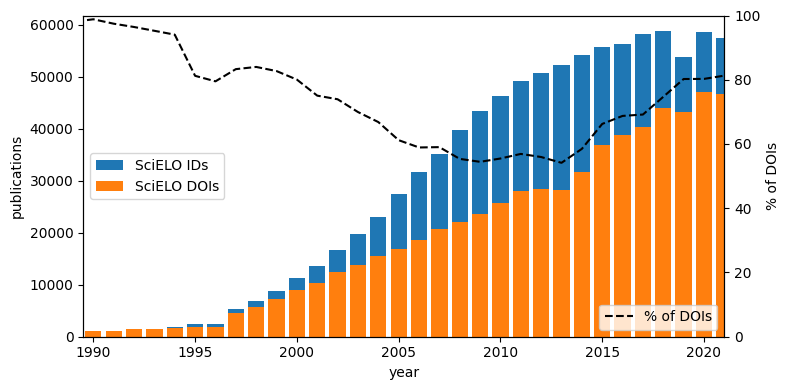

In [95]:
x = df['year'].values
dois = df['distinct_dois'].values
ids = df['distinct_ids'].values

fig, ax1 = plt.subplots(figsize=(8,4))

#color = 'tab:red'
ax1.set_xlabel('year')
ax1.set_ylabel('publications')
ax1.bar(x, ids, label='SciELO IDs')
ax1.bar(x, dois, label='SciELO DOIs')
#ax1.tick_params(axis='y', labelcolor=color)
plt.legend(loc='center left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
ax2.set_ylabel('% of DOIs')  # we already handled the x-label with ax1
ax2.plot(x, 100*dois/ids,'--k',label='% of DOIs')
#ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,100)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xlim([1989.5,2021])
#plt.xlim([0,100])
plt.legend(loc='lower right')
plt.show()


In [98]:
%%bigquery collections --project=insyspo

SELECT b.collection,
  COUNT(DISTINCT(a.doi)) AS ndoi,
  COUNT(DISTINCT(a.id)) AS n,
  COUNT(DISTINCT(a.doi))/COUNT(DISTINCT(a.id)) AS p
FROM `insyspo.publicdb_scielo_2024_rm.works` AS a
JOIN `insyspo.publicdb_scielo_2024_rm.works_biblio` AS b
ON a.id = b.id
GROUP BY collection
HAVING n>0
ORDER BY n DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [101]:
collections['p'] = np.rint(collections['p']*100)
collections

,collection,ndoi,n,p
0,SciELO Brazil,499782,515098,97.0
1,SciELO Mexico,39417,93622,42.0
2,SciELO Chile,68069,88459,77.0
3,SciELO Colombia,36270,77102,47.0
4,SciELO Argentina,11079,58302,19.0
5,SciELO Public Health,44083,51851,85.0
6,SciELO Spain,21675,49177,44.0
7,SciELO Cuba,332,47377,1.0
8,SciELO South Africa,26988,43144,63.0
9,SciELO Portugal,14189,29383,48.0


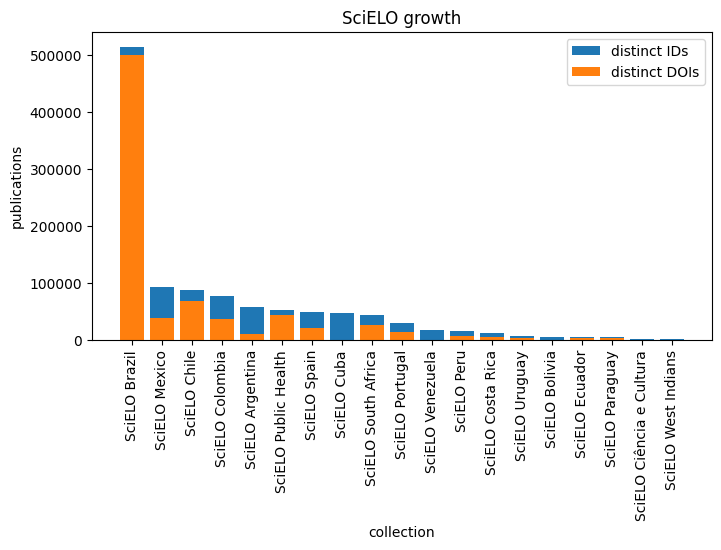

In [99]:
x = collections['collection'].values
ids = collections['n'].values
dois = collections['ndoi'].values

plt.figure(figsize=(8,4))
plt.bar(x,ids)
plt.bar(x,dois)
plt.title('SciELO growth')
plt.ylabel('publications')
plt.xlabel('collection')
plt.xticks(rotation=90)
plt.legend(['distinct IDs','distinct DOIs'])

# Comparison of metadata in SciELO and OpenAlex

Using cloud stored versions of both OpenAlex and SciELO, we match works with available DOIs and check differences in presence of metadata.

Works with DOIs.

In [5]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS insyspo.publicdb_scielo_2024_rm.scielo_dois;
CREATE TABLE insyspo.publicdb_scielo_2024_rm.scielo_dois AS (
  SELECT *
  FROM insyspo.publicdb_scielo_2024_rm.works
  WHERE doi IS NOT NULL
)

Query is running:   0%|          |

""


# DOIs with repetitions - problem

In [6]:
%%bigquery --project=insyspo

SELECT a.id, a.doi, COUNT(*) AS n
FROM insyspo.publicdb_scielo_2024_rm.scielo_dois AS a
LEFT JOIN insyspo.publicdb_scielo_2024_rm.works AS b
ON a.doi = SUBSTR(b.doi,17)
GROUP BY a.id, a.doi
ORDER BY n DESC

Query is running:   0%|          |

Downloading:   0%|          |

,id,doi,n
0,S0102-86502004000700001,10.1590/S0102-86502004000700001,2
1,S0102-86502011000100015,10.1590/S0102-86502011000100015,2
2,S1679-45082013000200024,10.1590/S1679-45082013000200024,2
3,S1679-45082014000100027,10.1590/S1679-45082014CE3052,2
4,S1679-45082014000300389,10.1590/s1679-45082014ce3126,2
...,...,...,...
766185,S2675-28242024000200400,10.1590/2675-2824072.23134,1
766186,S2675-94622021000100600,10.51694/advweedsci/2021;39:00006,1
766187,S2675-94622022000200600,10.51694/advweedsci/2022;40:amaranthus008,1
766188,S2675-94622023000100600,10.51694/advweedsci/2023;41:00015,1


In [7]:
%%bigquery --project=insyspo

SELECT *
FROM  insyspo.publicdb_openalex_2024_04_rm.works
WHERE doi = '10.1016/j.bmhimx.2015.01.004'

Query is running:   0%|          |

Downloading:   0%|          |

,id,is_retracted,display_name,title,institutions_distinct_count,locations_count,referenced_works_count,authors_count,concepts_count,cited_by_count,...,publication_date,updated,updated_date,publication_year,doi,language,oa_status,oa_url,is_oa,any_repository_has_full_text
0,2167414585,False,Diabetes insípida nefrogénica,Diabetes insípida nefrogénica,1,3,30,2,12,2,...,2014-11-01,2024-03-20 17:07:32.946583,2024-03-20 17:07:32.946583,2014,10.1016/j.bmhimx.2015.01.004,es,gold,https://doi.org/10.1016/j.bmhimx.2015.01.004,True,<NA>


# Comparison of metadata

In [128]:
T = pd.DataFrame({'metric':[],'Equal':[],'Larger SciELO': [], 'Larger OpenAlex': [],'Total':[]})

## Authors

In [104]:
%%bigquery authors_scielo_openalex --project=insyspo

WITH match_scielo_oa AS (
  SELECT a.id AS scielo_id, a.doi AS doi, b.id AS oa_id
  FROM insyspo.publicdb_scielo_2024_rm.scielo_dois AS a
  LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS b
  ON LOWER(a.doi) = LOWER(b.doi)
  ORDER BY a.id
)
SELECT doi,
  MAX(b.author_order) AS n_authors_scielo,
  COUNT(DISTINCT(c.author_id)) AS n_authors_oa,
  MAX(b.author_order)=COUNT(DISTINCT(c.author_id)) AS n_equal,
  MAX(b.author_order)>COUNT(DISTINCT(c.author_id)) AS n_scielo_larger,
FROM match_scielo_oa AS a
LEFT JOIN insyspo.publicdb_scielo_2024_rm.works_authors AS b
ON a.scielo_id = b.id
LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works_authorships AS c
ON a.oa_id = c.work_id
GROUP BY doi

Query is running:   0%|          |

Downloading:   0%|          |

In [129]:
equal = authors_scielo_openalex['n_equal'].sum()
scielo_larger =  authors_scielo_openalex['n_scielo_larger'].sum()
n = authors_scielo_openalex.shape[0]
openalex_larger =  n-equal-scielo_larger

xticks = ['Equal','Larger SciELO','Larger OpenAlex','Total']
x = [equal,scielo_larger,openalex_larger,n]
Ti = pd.DataFrame({'metric':['authors'],'Equal':[equal],'Larger SciELO': [scielo_larger], 'Larger OpenAlex': [openalex_larger],'Total':[n]})
T = pd.concat((T,Ti),axis='index')

Text(0, 0.5, 'Number of works')

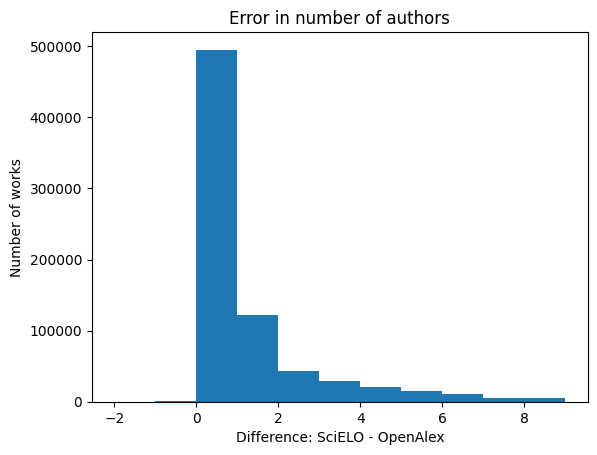

In [107]:
d = authors_scielo_openalex['n_authors_scielo']-authors_scielo_openalex['n_authors_oa']
plt.hist(d,bins=[-2,-1,0,1,2,3,4,5,6,7,8,9])
plt.title('Error in number of authors')
plt.xlabel('Difference: SciELO - OpenAlex')
plt.ylabel('Number of works')

## Affiliations

In [108]:
%%bigquery affiliations_scielo_openalex --project=insyspo

WITH match_scielo_oa AS (
  SELECT a.id AS scielo_id, a.doi AS doi, b.id AS oa_id
  FROM insyspo.publicdb_scielo_2024_rm.scielo_dois AS a
  LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS b
  ON LOWER(a.doi) = LOWER(b.doi)
  ORDER BY a.id
)
SELECT doi,
  MAX(b.affiliation_order) AS n_affiliations_scielo,
  COUNT(DISTINCT(c.institution_id)) AS n_affiliations_oa,
  MAX(b.affiliation_order)=COUNT(DISTINCT(c.institution_id)) AS n_equal,
  MAX(b.affiliation_order)>COUNT(DISTINCT(c.institution_id)) AS n_scielo_larger,
FROM match_scielo_oa AS a
LEFT JOIN insyspo.publicdb_scielo_2024_rm.works_affiliations AS b
ON a.scielo_id = b.id
LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works_authorships AS c
ON a.oa_id = c.work_id
GROUP BY doi

Query is running:   0%|          |

Downloading:   0%|          |

In [130]:
equal = affiliations_scielo_openalex['n_equal'].sum()
scielo_larger =  affiliations_scielo_openalex['n_scielo_larger'].sum()
n = affiliations_scielo_openalex.shape[0]
openalex_larger =  n-equal-scielo_larger

xticks = ['Equal','Larger SciELO','Larger OpenAlex','Total']
x = [equal,scielo_larger,openalex_larger,n]
Ti = pd.DataFrame({'metric':['affiliations'],'Equal':[equal],'Larger SciELO': [scielo_larger], 'Larger OpenAlex': [openalex_larger],'Total':[n]})
T = pd.concat((T,Ti),axis='index')

Text(0, 0.5, 'Number of works')

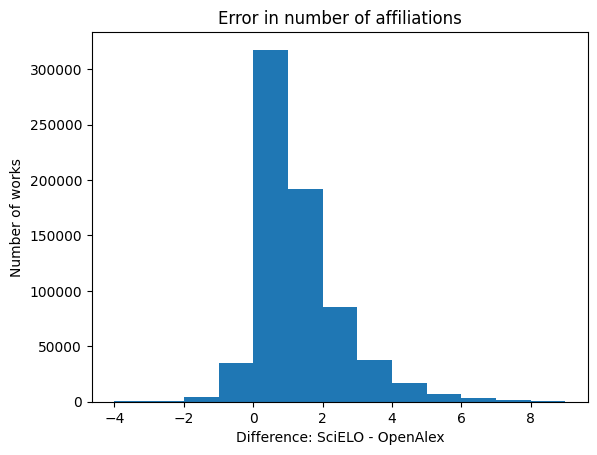

In [112]:
d = affiliations_scielo_openalex['n_affiliations_scielo']-affiliations_scielo_openalex['n_affiliations_oa']
plt.hist(d.dropna(),bins=[-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
plt.title('Error in number of affiliations')
plt.xlabel('Difference: SciELO - OpenAlex')
plt.ylabel('Number of works')

## References

In [113]:
%%bigquery references_scielo_openalex --project=insyspo

WITH match_scielo_oa AS (
  SELECT a.id AS scielo_id, a.doi AS doi, b.id AS oa_id
  FROM insyspo.publicdb_scielo_2024_rm.scielo_dois AS a
  LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS b
  ON LOWER(a.doi) = LOWER(SUBSTR(b.doi,17))
  ORDER BY a.id
)
SELECT doi,
  MAX(b.reference_order) AS n_references_scielo,
  COUNT(DISTINCT(c.referenced_work_id)) AS n_references_oa,
  MAX(b.reference_order)=COUNT(DISTINCT(c.referenced_work_id)) AS n_equal,
  MAX(b.reference_order)>COUNT(DISTINCT(c.referenced_work_id)) AS n_scielo_larger,
FROM match_scielo_oa AS a
LEFT JOIN insyspo.publicdb_scielo_2024_rm.works_references AS b
ON a.scielo_id = b.id
LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works_referenced_works AS c
ON a.oa_id = c.work_id
GROUP BY doi

Query is running:   0%|          |

Downloading:   0%|          |

In [131]:
equal = references_scielo_openalex['n_equal'].sum()
scielo_larger =  references_scielo_openalex['n_scielo_larger'].sum()
n = references_scielo_openalex.shape[0]
openalex_larger =  n-equal-scielo_larger

xticks = ['Equal','Larger SciELO','Larger OpenAlex','Total']
x = [equal,scielo_larger,openalex_larger,n]
Ti = pd.DataFrame({'metric':['references'],'Equal':[equal],'Larger SciELO': [scielo_larger], 'Larger OpenAlex': [openalex_larger],'Total':[n]})
T = pd.concat((T,Ti),axis='index')

Text(0, 0.5, 'Number of works')

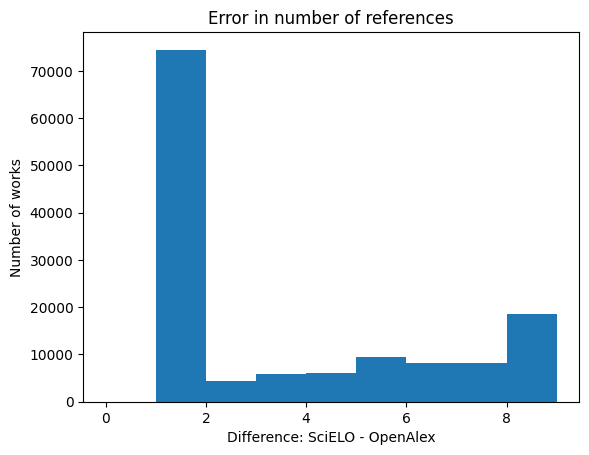

In [116]:
d = references_scielo_openalex['n_references_scielo']-references_scielo_openalex['n_references_oa']
plt.hist(d.dropna(),bins=[0,1,2,3,4,5,6,7,8,9])
plt.title('Error in number of references')
plt.xlabel('Difference: SciELO - OpenAlex')
plt.ylabel('Number of works')

## Abstracts

In [117]:
%%bigquery abstracts_scielo_openalex --project=insyspo

WITH match_scielo_oa AS (
  SELECT a.id AS scielo_id, a.doi AS doi, b.id AS oa_id
  FROM insyspo.publicdb_scielo_2024_rm.scielo_dois AS a
  LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS b
  ON LOWER(a.doi) = LOWER(b.doi)
  ORDER BY a.id
)
SELECT a.doi,
  COUNT(b.text) AS n_abstracts_scielo,
  COUNT(c.abstract_inverted_index) AS n_abstracts_oa,
  COUNT(b.text)=COUNT(c.abstract_inverted_index) AS n_equal,
  COUNT(b.text)>COUNT(c.abstract_inverted_index) AS n_scielo_larger,
FROM match_scielo_oa AS a
LEFT JOIN insyspo.publicdb_scielo_2024_rm.works_abstracts AS b
ON a.scielo_id = b.id
LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works_inverted_abstracts AS c
ON a.oa_id = c.id
GROUP BY a.doi

Query is running:   0%|          |

Downloading:   0%|          |

In [132]:
equal = abstracts_scielo_openalex['n_equal'].sum()
scielo_larger =  abstracts_scielo_openalex['n_scielo_larger'].sum()
n = abstracts_scielo_openalex.shape[0]
openalex_larger =  n-equal-scielo_larger

xticks = ['Equal','Larger SciELO','Larger OpenAlex','Total']
x = [equal,scielo_larger,openalex_larger,n]
Ti = pd.DataFrame({'metric':['abstracts'],'Equal':[equal],'Larger SciELO': [scielo_larger], 'Larger OpenAlex': [openalex_larger],'Total':[n]})
T = pd.concat((T,Ti),axis='index')

Text(0, 0.5, 'Number of works')

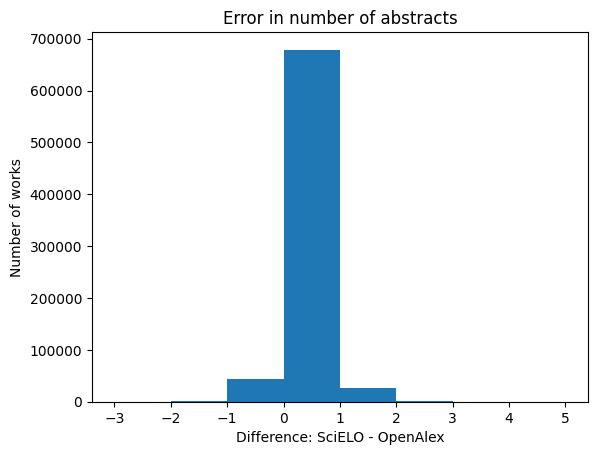

In [119]:
d = abstracts_scielo_openalex['n_abstracts_scielo']-abstracts_scielo_openalex['n_abstracts_oa']
plt.hist(d.dropna(),bins=[-3,-2,-1,0,1,2,3,4,5])
plt.title('Error in number of abstracts')
plt.xlabel('Difference: SciELO - OpenAlex')
plt.ylabel('Number of works')

## DOIs of references

In [120]:
%%bigquery doi_references_scielo_openalex --project=insyspo

WITH match_scielo_oa AS (
  SELECT a.id AS scielo_id, a.doi AS doi, b.id AS oa_id
  FROM insyspo.publicdb_scielo_2024_rm.scielo_dois AS a
  LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS b
  ON LOWER(a.doi) = LOWER(b.doi)
  ORDER BY a.id
)
SELECT a.doi,
  COUNTIF(b.uri LIKE '%doi%') AS n_doi_refs_scielo,
  COUNT(d.doi) AS n_doi_refs_oa,
  COUNTIF(b.uri LIKE '%doi%')=COUNT(d.doi) AS n_equal,
  COUNTIF(b.uri LIKE '%doi%')>COUNT(d.doi) AS n_scielo_larger,
FROM match_scielo_oa AS a
LEFT JOIN insyspo.publicdb_scielo_2024_rm.works_references AS b
ON a.scielo_id = b.id
LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works_referenced_works AS c
ON a.oa_id = c.work_id
LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS d
ON c.referenced_work_id = d.id
GROUP BY a.doi

Query is running:   0%|          |

Downloading:   0%|          |

In [133]:
equal = doi_references_scielo_openalex['n_equal'].sum()
scielo_larger =  doi_references_scielo_openalex['n_scielo_larger'].sum()
n = doi_references_scielo_openalex.shape[0]
openalex_larger =  n-equal-scielo_larger

xticks = ['Equal','Larger SciELO','Larger OpenAlex','Total']
x = [equal,scielo_larger,openalex_larger,n]
Ti = pd.DataFrame({'metric':['dois of references'],'Equal':[equal],'Larger SciELO': [scielo_larger], 'Larger OpenAlex': [openalex_larger],'Total':[n]})
T = pd.concat((T,Ti),axis='index')

Text(0, 0.5, 'Number of works')

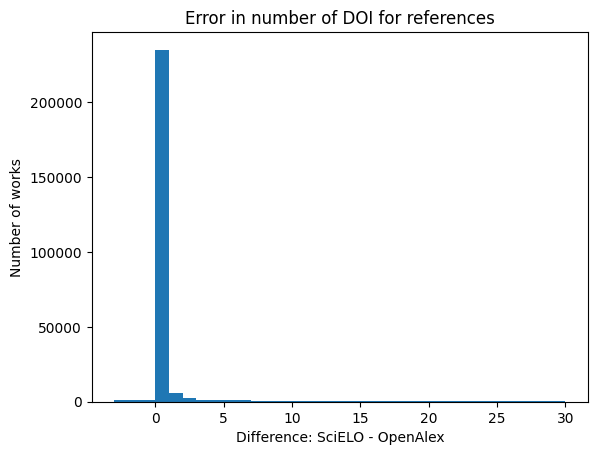

In [122]:
d = doi_references_scielo_openalex['n_doi_refs_scielo']-doi_references_scielo_openalex['n_doi_refs_oa']
plt.hist(d.dropna(),bins=[-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30])
plt.title('Error in number of DOI for references')
plt.xlabel('Difference: SciELO - OpenAlex')
plt.ylabel('Number of works')

## Results' table

In [134]:
T

,metric,Equal,Larger SciELO,Larger OpenAlex,Total
0,authors,495155.0,255232.0,1068.0,751455.0
0,affiliations,317646.0,346457.0,87352.0,751455.0
0,references,0.0,751455.0,0.0,751455.0
0,abstracts,678805.0,27430.0,45220.0,751455.0
0,dois of references,234972.0,26670.0,489813.0,751455.0


In [137]:
T['p'] = T['Equal']/T['Total']*100
T

,metric,Equal,Larger SciELO,Larger OpenAlex,Total,p
0,authors,495155.0,255232.0,1068.0,751455.0,65.892835
0,affiliations,317646.0,346457.0,87352.0,751455.0,42.270795
0,references,0.0,751455.0,0.0,751455.0,0.000000
0,abstracts,678805.0,27430.0,45220.0,751455.0,90.332089
0,dois of references,234972.0,26670.0,489813.0,751455.0,31.268938


In [135]:
T['Larger OpenAlex']/T['Total']

0    0.001421
0    0.116244
0    0.000000
0    0.060177
0    0.651819
dtype: float64

In [136]:
T['Larger SciELO']/T['Total']

0    0.339650
0    0.461048
0    1.000000
0    0.036503
0    0.035491
dtype: float64

# Comparison of metadata along time

## Authors

In [140]:
%%bigquery authors_scielo_openalex --project=insyspo

SELECT SUM(IF(n_equal,1,0)) AS n_equal,
  SUM(IF(n_scielo_larger,1,0)) AS n_scielo_larger,
  COUNT(*) AS total,
  publication_year
FROM (
    WITH match_scielo_oa AS (
      SELECT a.id AS scielo_id, a.doi AS doi, b.id AS oa_id, b.publication_year
      FROM insyspo.publicdb_scielo_2024_rm.scielo_dois AS a
      LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS b
      ON LOWER(a.doi) = LOWER(b.doi)
      ORDER BY a.id
    )
    SELECT doi,
      MAX(b.author_order) AS n_authors_scielo,
      COUNT(DISTINCT(c.author_id)) AS n_authors_oa,
      MAX(b.author_order)=COUNT(DISTINCT(c.author_id)) AS n_equal,
      MAX(b.author_order)>COUNT(DISTINCT(c.author_id)) AS n_scielo_larger,
      publication_year
    FROM match_scielo_oa AS a
    LEFT JOIN insyspo.publicdb_scielo_2024_rm.works_authors AS b
    ON a.scielo_id = b.id
    LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works_authorships AS c
    ON a.oa_id = c.work_id
    WHERE publication_year IS NOT NULL
      AND publication_year > 1990
      AND publication_year < 2021
    GROUP BY doi, publication_year
)
GROUP BY publication_year
ORDER BY publication_year ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [141]:
authors_scielo_openalex

,n_equal,n_scielo_larger,total,publication_year
0,646,493,1139,1991
1,875,596,1471,1992
2,894,592,1486,1993
3,1069,668,1737,1994
4,1088,848,1936,1995
5,1175,780,1956,1996
6,2291,2187,4479,1997
7,2920,2743,5672,1998
8,3974,3280,7257,1999
9,4942,3763,8706,2000


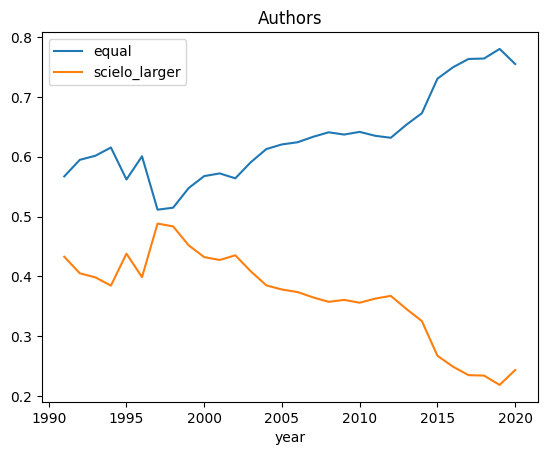

In [142]:
aa = pd.DataFrame()
aa['equal'] = authors_scielo_openalex['n_equal']/authors_scielo_openalex['total']
aa['scielo_larger'] = authors_scielo_openalex['n_scielo_larger']/authors_scielo_openalex['total']
aa['year'] = authors_scielo_openalex['publication_year']
aa.plot.line(x='year')
plt.title('Authors')

authors_table = pd.DataFrame()
authors_table['authors'] = aa['equal']
authors_table['year'] = aa['year']

Text(0.5, 1.0, 'Authors')

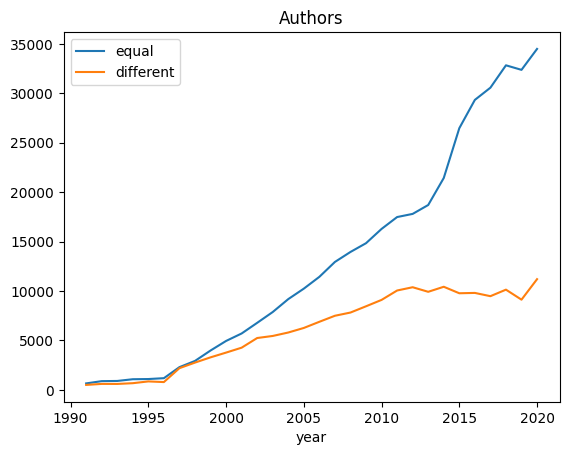

In [52]:
aa = pd.DataFrame()
aa['equal'] = authors_scielo_openalex['n_equal']
aa['different'] = authors_scielo_openalex['total']-authors_scielo_openalex['n_equal']
aa['year'] = authors_scielo_openalex['publication_year']
aa.plot.line(x='year')
plt.title('Authors')

In [53]:
aa

,equal,different,year
0,646,493,1991
1,875,596,1992
2,894,592,1993
3,1069,668,1994
4,1088,848,1995
5,1175,781,1996
6,2291,2188,1997
7,2920,2752,1998
8,3974,3283,1999
9,4942,3764,2000


Text(0.5, 1.0, 'Authors')

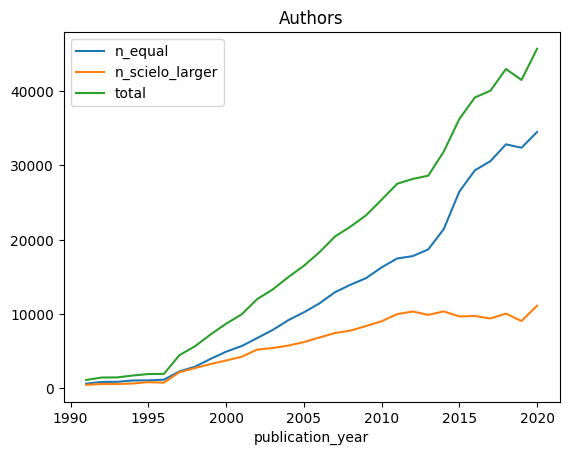

In [54]:
authors_scielo_openalex.plot.line(x='publication_year')
plt.title('Authors')

## Affiliations

In [143]:
%%bigquery affiliations_scielo_openalex --project=insyspo


SELECT SUM(IF(n_equal,1,0)) AS n_equal,
  SUM(IF(n_scielo_larger,1,0)) AS n_scielo_larger,
  COUNT(*) AS total,
  publication_year
FROM (
  WITH match_scielo_oa AS (
    SELECT a.id AS scielo_id, a.doi AS doi, b.id AS oa_id, b.publication_year
    FROM insyspo.publicdb_scielo_2024_rm.scielo_dois AS a
    LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS b
    ON LOWER(a.doi) = LOWER(b.doi)
    ORDER BY a.id
  )
  SELECT doi,
    MAX(b.affiliation_order) AS n_affiliations_scielo,
    COUNT(DISTINCT(c.institution_id)) AS n_affiliations_oa,
    MAX(b.affiliation_order)=COUNT(DISTINCT(c.institution_id)) AS n_equal,
    MAX(b.affiliation_order)>COUNT(DISTINCT(c.institution_id)) AS n_scielo_larger,
    a.publication_year
  FROM match_scielo_oa AS a
  LEFT JOIN insyspo.publicdb_scielo_2024_rm.works_affiliations AS b
  ON a.scielo_id = b.id
  LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works_authorships AS c
  ON a.oa_id = c.work_id
  WHERE publication_year IS NOT NULL
      AND publication_year > 1990
      AND publication_year < 2021
  GROUP BY doi, publication_year
)
GROUP BY publication_year
ORDER BY publication_year ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [144]:
affiliations_scielo_openalex

,n_equal,n_scielo_larger,total,publication_year
0,460,426,1139,1991
1,628,494,1471,1992
2,637,495,1486,1993
3,759,571,1737,1994
4,794,662,1936,1995
5,818,640,1956,1996
6,1644,1478,4479,1997
7,2283,2100,5672,1998
8,2877,2775,7257,1999
9,3478,3355,8706,2000


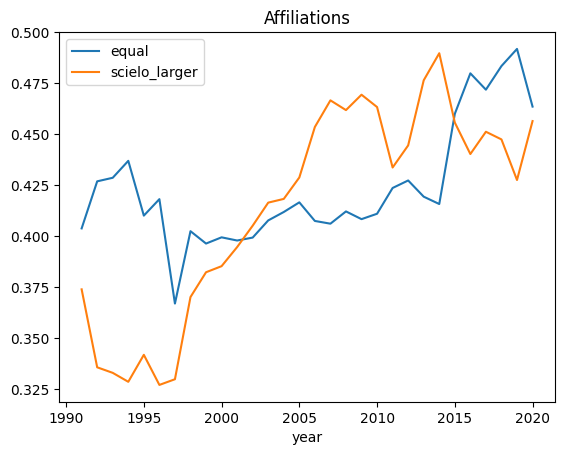

In [145]:
aa = pd.DataFrame()
aa['equal'] = affiliations_scielo_openalex['n_equal']/affiliations_scielo_openalex['total']
aa['scielo_larger'] = affiliations_scielo_openalex['n_scielo_larger']/affiliations_scielo_openalex['total']
aa['year'] = affiliations_scielo_openalex['publication_year']
aa.plot.line(x='year')
plt.title('Affiliations')

affiliations_table = pd.DataFrame()
affiliations_table['affiliations'] = aa['equal']
affiliations_table['year'] = aa['year']

Text(0.5, 1.0, 'Affiliations')

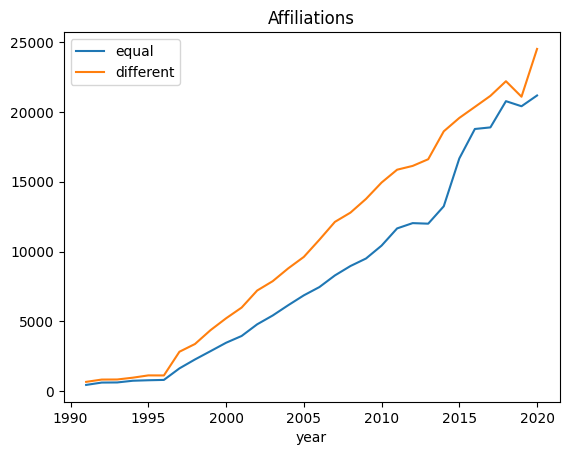

In [64]:
aa = pd.DataFrame()
aa['equal'] = affiliations_scielo_openalex['n_equal']
aa['different'] = affiliations_scielo_openalex['total']-affiliations_scielo_openalex['n_equal']
aa['year'] = affiliations_scielo_openalex['publication_year']
aa.plot.line(x='year')
plt.title('Affiliations')

In [67]:
aa

,equal,different,year
0,460,679,1991
1,628,843,1992
2,637,849,1993
3,759,978,1994
4,794,1142,1995
5,818,1138,1996
6,1644,2835,1997
7,2283,3389,1998
8,2877,4380,1999
9,3478,5228,2000


Text(0.5, 1.0, 'Affiliations')

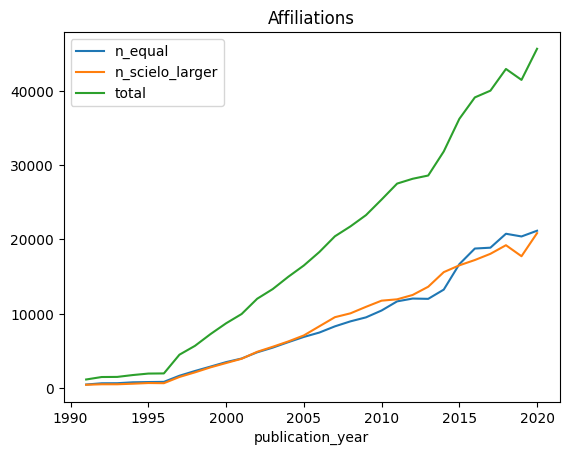

In [68]:
affiliations_scielo_openalex.plot.line(x='publication_year')
plt.title('Affiliations')

## References

In [146]:
%%bigquery references_scielo_openalex --project=insyspo

SELECT SUM(IF(n_equal,1,0)) AS n_equal,
  SUM(IF(n_scielo_larger,1,0)) AS n_scielo_larger,
  COUNT(*) AS total,
  publication_year
FROM (
  WITH match_scielo_oa AS (
    SELECT a.id AS scielo_id, a.doi AS doi, b.id AS oa_id, b.publication_year
    FROM insyspo.publicdb_scielo_2024_rm.scielo_dois AS a
    LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS b
    ON LOWER(a.doi) = LOWER(b.doi)
    ORDER BY a.id
  )
  SELECT doi,
    MAX(b.reference_order) AS n_references_scielo,
    COUNT(DISTINCT(c.referenced_work_id)) AS n_references_oa,
    MAX(b.reference_order)=COUNT(DISTINCT(c.referenced_work_id)) AS n_equal,
    MAX(b.reference_order)>COUNT(DISTINCT(c.referenced_work_id)) AS n_scielo_larger,
    a.publication_year
  FROM match_scielo_oa AS a
  LEFT JOIN insyspo.publicdb_scielo_2024_rm.works_references AS b
  ON a.scielo_id = b.id
  LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works_referenced_works AS c
  ON a.oa_id = c.work_id
  WHERE a.publication_year IS NOT NULL
      AND publication_year > 1990
      AND publication_year < 2021
  GROUP BY doi, publication_year
)
GROUP BY publication_year
ORDER BY publication_year ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [147]:
references_scielo_openalex

,n_equal,n_scielo_larger,total,publication_year
0,5,1088,1139,1991
1,9,1413,1471,1992
2,13,1424,1486,1993
3,13,1689,1737,1994
4,8,1882,1936,1995
5,25,1883,1956,1996
6,24,4360,4479,1997
7,32,5540,5672,1998
8,58,7073,7257,1999
9,64,8528,8706,2000


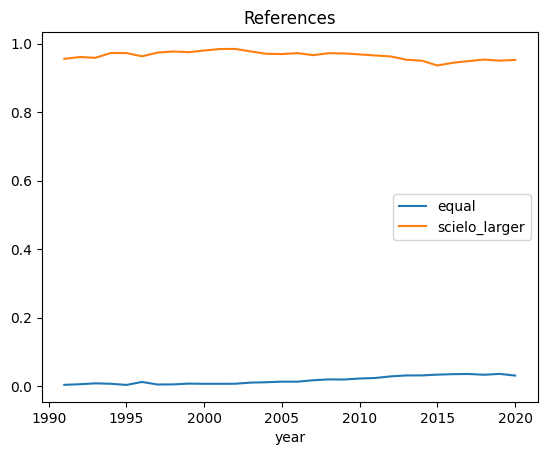

In [148]:
aa = pd.DataFrame()
aa['equal'] = references_scielo_openalex['n_equal']/references_scielo_openalex['total']
aa['scielo_larger'] = references_scielo_openalex['n_scielo_larger']/references_scielo_openalex['total']
aa['year'] = references_scielo_openalex['publication_year']

aa.plot.line(x='year')
plt.title('References')

references_table = pd.DataFrame()
references_table['references'] = aa['equal']
references_table['year'] = aa['year']

Text(0.5, 1.0, 'References')

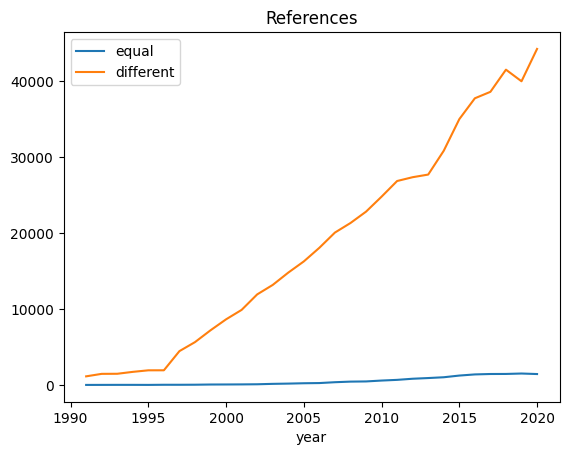

In [73]:
aa = pd.DataFrame()
aa['equal'] = references_scielo_openalex['n_equal']
aa['different'] = references_scielo_openalex['total']-references_scielo_openalex['n_equal']
aa['year'] = references_scielo_openalex['publication_year']
aa.plot.line(x='year')
plt.title('References')

In [74]:
aa

,equal,different,year
0,5,1134,1991
1,9,1462,1992
2,13,1473,1993
3,13,1724,1994
4,8,1928,1995
5,25,1931,1996
6,24,4455,1997
7,32,5640,1998
8,58,7199,1999
9,64,8642,2000


Text(0.5, 1.0, 'References')

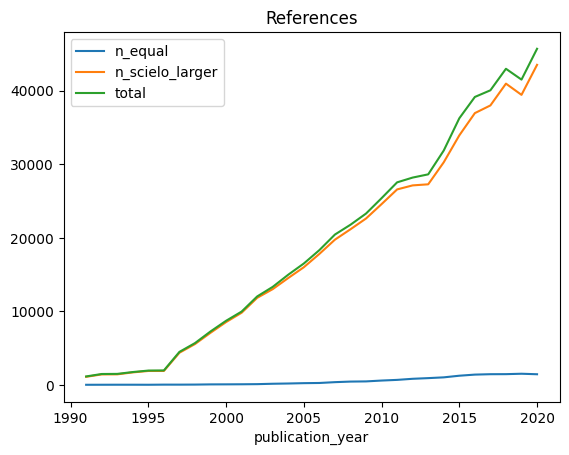

In [75]:
references_scielo_openalex.plot.line(x='publication_year')
plt.title('References')

## Abstracts

In [149]:
%%bigquery abstracts_scielo_openalex --project=insyspo

SELECT SUM(IF(n_equal,1,0)) AS n_equal,
  SUM(IF(n_scielo_larger,1,0)) AS n_scielo_larger,
  COUNT(*) AS total,
  publication_year
FROM (
  WITH match_scielo_oa AS (
    SELECT a.id AS scielo_id, a.doi AS doi, b.id AS oa_id, b.publication_year
    FROM insyspo.publicdb_scielo_2024_rm.scielo_dois AS a
    LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS b
    ON LOWER(a.doi) = LOWER(b.doi)
    ORDER BY a.id
  )
  SELECT a.doi,
    COUNT(b.text) AS n_abstracts_scielo,
    COUNT(c.abstract_inverted_index) AS n_abstracts_oa,
    COUNT(b.text)=COUNT(c.abstract_inverted_index) AS n_equal,
    COUNT(b.text)>COUNT(c.abstract_inverted_index) AS n_scielo_larger,
    a.publication_year
  FROM match_scielo_oa AS a
  LEFT JOIN insyspo.publicdb_scielo_2024_rm.works_abstracts AS b
  ON a.scielo_id = b.id
  LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works_inverted_abstracts AS c
  ON a.oa_id = c.id
  WHERE a.publication_year IS NOT NULL
      AND a.publication_year > 1990
      AND a.publication_year < 2021
  GROUP BY a.doi, a.publication_year
)
GROUP BY publication_year
ORDER BY publication_year ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [150]:
abstracts_scielo_openalex

,n_equal,n_scielo_larger,total,publication_year
0,1006,5,1139,1991
1,1340,9,1471,1992
2,1337,9,1486,1993
3,1568,10,1737,1994
4,1677,12,1936,1995
5,1735,1,1956,1996
6,3977,15,4479,1997
7,5074,33,5672,1998
8,6485,9,7257,1999
9,7909,7,8706,2000


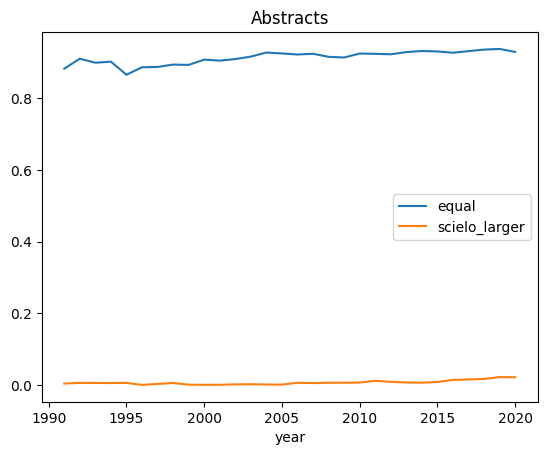

In [151]:
aa = pd.DataFrame()
aa['equal'] = abstracts_scielo_openalex['n_equal']/abstracts_scielo_openalex['total']
aa['scielo_larger'] = abstracts_scielo_openalex['n_scielo_larger']/abstracts_scielo_openalex['total']
aa['year'] = abstracts_scielo_openalex['publication_year']

aa.plot.line(x='year')
plt.title('Abstracts')

abstracts_table = pd.DataFrame()
abstracts_table['abstracts'] = aa['equal']
abstracts_table['year'] = aa['year']

Text(0.5, 1.0, 'Abstracts')

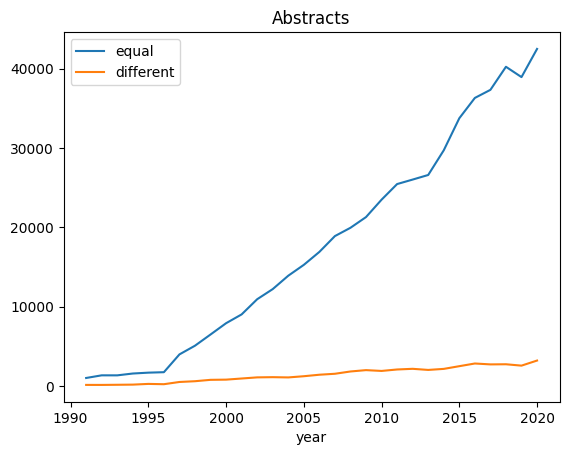

In [82]:
aa = pd.DataFrame()
aa['equal'] = abstracts_scielo_openalex['n_equal']
aa['different'] = abstracts_scielo_openalex['total']-abstracts_scielo_openalex['n_equal']
aa['year'] = abstracts_scielo_openalex['publication_year']
aa.plot.line(x='year')
plt.title('Abstracts')

In [83]:
aa

,equal,different,year
0,1006,133,1991
1,1340,131,1992
2,1337,149,1993
3,1568,169,1994
4,1677,259,1995
5,1735,221,1996
6,3977,502,1997
7,5074,598,1998
8,6485,772,1999
9,7909,797,2000


Text(0.5, 1.0, 'Abstracts')

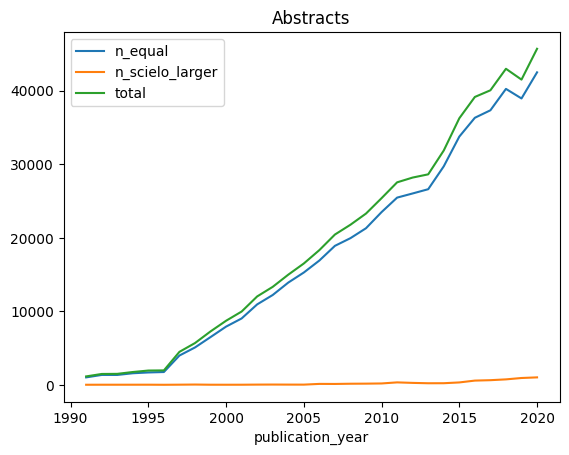

In [84]:
abstracts_scielo_openalex.plot.line(x='publication_year')
plt.title('Abstracts')

## DOIs of references

In [152]:
%%bigquery doi_references_scielo_openalex --project=insyspo

SELECT SUM(IF(n_equal,1,0)) AS n_equal,
  SUM(IF(n_scielo_larger,1,0)) AS n_scielo_larger,
  COUNT(*) AS total,
  publication_year
FROM (
  WITH match_scielo_oa AS (
    SELECT a.id AS scielo_id, a.doi AS doi, b.id AS oa_id, b.publication_year
    FROM insyspo.publicdb_scielo_2024_rm.scielo_dois AS a
    LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS b
    ON LOWER(a.doi) = LOWER(b.doi)
    ORDER BY a.id
  )
  SELECT a.doi,
    COUNTIF(b.uri LIKE '%doi%') AS n_doi_refs_scielo,
    COUNT(d.doi) AS n_doi_refs_oa,
    COUNTIF(b.uri LIKE '%doi%')=COUNT(d.doi) AS n_equal,
    COUNTIF(b.uri LIKE '%doi%')>COUNT(d.doi) AS n_scielo_larger,
    a.publication_year
  FROM match_scielo_oa AS a
  LEFT JOIN insyspo.publicdb_scielo_2024_rm.works_references AS b
  ON a.scielo_id = b.id
  LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works_referenced_works AS c
  ON a.oa_id = c.work_id
  LEFT JOIN insyspo.publicdb_openalex_2024_04_rm.works AS d
  ON c.referenced_work_id = d.id
  WHERE a.publication_year IS NOT NULL
      AND a.publication_year > 1990
      AND a.publication_year < 2021
  GROUP BY a.doi, a.publication_year
)
GROUP BY publication_year
ORDER BY publication_year ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [153]:
doi_references_scielo_openalex

,n_equal,n_scielo_larger,total,publication_year
0,565,0,1139,1991
1,817,0,1471,1992
2,671,0,1486,1993
3,816,0,1737,1994
4,885,0,1936,1995
5,715,0,1956,1996
6,2078,0,4479,1997
7,2466,0,5672,1998
8,2710,0,7257,1999
9,3190,0,8706,2000


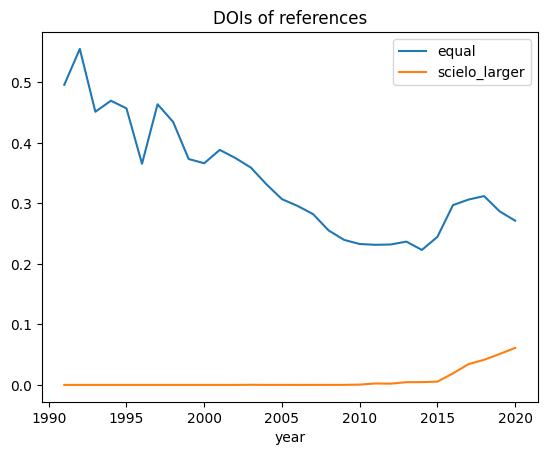

In [154]:
aa = pd.DataFrame()
aa['equal'] = doi_references_scielo_openalex['n_equal']/doi_references_scielo_openalex['total']
aa['scielo_larger'] = doi_references_scielo_openalex['n_scielo_larger']/doi_references_scielo_openalex['total']
aa['year'] = doi_references_scielo_openalex['publication_year']

aa.plot.line(x='year')
plt.title('DOIs of references')

dois_refs_table = pd.DataFrame()
dois_refs_table['dois_refs'] = aa['equal']
dois_refs_table['year'] = aa['year']

Text(0.5, 1.0, 'DOIs of references')

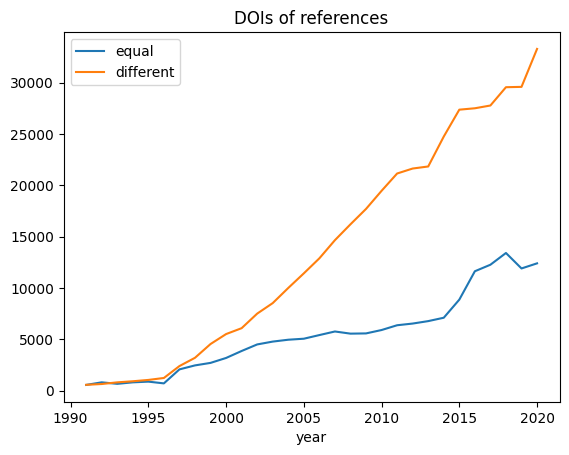

In [88]:
aa = pd.DataFrame()
aa['equal'] = doi_references_scielo_openalex['n_equal']
aa['different'] = doi_references_scielo_openalex['total']-doi_references_scielo_openalex['n_equal']
aa['year'] = doi_references_scielo_openalex['publication_year']
aa.plot.line(x='year')
plt.title('DOIs of references')

In [89]:
aa

,equal,different,year
0,565,574,1991
1,817,654,1992
2,671,815,1993
3,816,921,1994
4,885,1051,1995
5,715,1241,1996
6,2078,2401,1997
7,2466,3206,1998
8,2710,4547,1999
9,3190,5516,2000


Text(0.5, 1.0, 'DOIs')

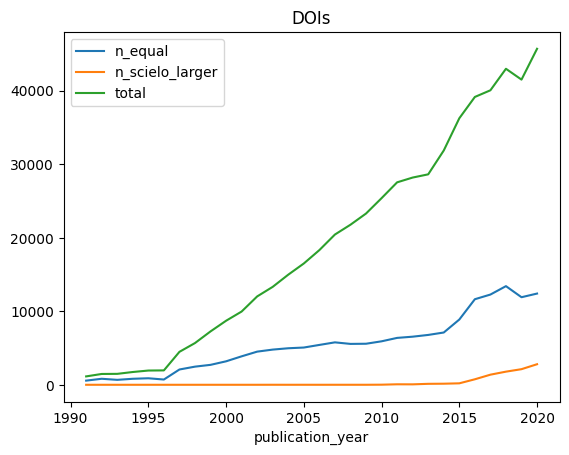

In [90]:
doi_references_scielo_openalex.plot.line(x='publication_year')
plt.title('DOIs')

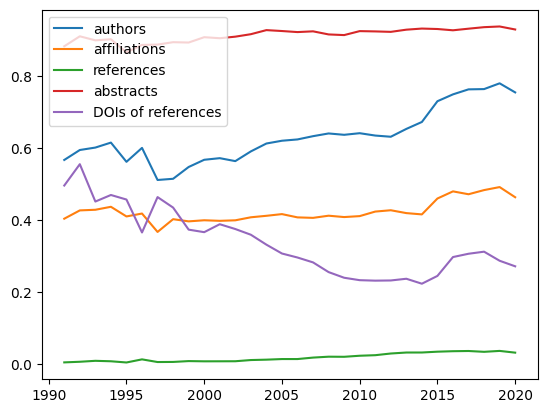

In [158]:
a = authors_table
plt.plot(a['year'],a['authors'],label='authors')
a = affiliations_table
plt.plot(a['year'],a['affiliations'],label='affiliations')
a = references_table
plt.plot(a['year'],a['references'],label='references')
a = abstracts_table
plt.plot(a['year'],a['abstracts'],label='abstracts')
a = dois_refs_table
plt.plot(a['year'],a['dois_refs'],label='DOIs of references')
plt.legend()